# **Bibliotecas**

In [16]:
import numpy as np  # Biblioteca para operações numéricas e manipulação eficiente de arrays.
import matplotlib.pyplot as plt  # Biblioteca para criar gráficos e visualizações de dados.
from scipy.signal import find_peaks  # Função para identificar picos em dados unidimensionais.
import tkinter as tk # Biblioteca para criar interface gráica
from matplotlib.figure import Figure # Biblioteca para gerar figuras
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg # Bilbioteca para transportar figurar matplotlib para interface gráfica

# **Funções do Simulador**

In [17]:
# Criação de um array temporal baseado em parâmetros de repetição (PRI) e frequência de amostragem (fs).
def create_time_array(qnt, PRI, fs):
    t_total = qnt * PRI  # Duração total do sinal (tempo total).
    t = np.linspace(0, t_total, int(fs * t_total), endpoint=False)  # Criação de um vetor temporal.
    return t


# Geração de um sinal transmitido com parâmetros definidos.
def generate_transmitted_signal(pulse_width, fs, PRI, power_tx, qnt):
    t = create_time_array(qnt, PRI, fs)  # Vetor de tempo.
    signal = np.zeros_like(t)  # Inicializa o sinal com zeros.

    # Duração do pulso em amostras.
    pulso_samples = int(pulse_width * fs)

    for i in range(qnt):  # Para cada PRI, insere um pulso.
        pri_offset = int(i * PRI * fs)  # Deslocamento temporal de cada PRI.
        inicio_pulso = pri_offset
        fim_pulso = inicio_pulso + pulso_samples

        if fim_pulso < len(signal):  # Verifica se o índice está dentro do limite.
            signal[inicio_pulso:fim_pulso] = np.sqrt(2*power_tx)
    return signal


# Geração do sinal recebido, considerando o atraso causado pela posição do alvo.
def generate_received_signal(pulse_width, fs, PRI, pos, Pr, qnt):
    t = create_time_array(qnt, PRI, fs)  # Vetor de tempo.
    signal = np.zeros_like(t)  # Inicializa o sinal com zeros.

    c = 3e8
    # Cálculo do atraso de ida e volta.
    delay = 2 * pos / c  # Atraso total (ida e volta).

    # Índices do pulso ajustados ao atraso.
    inicio_pulso = int(delay * fs)

    for i in range(qnt):  # Para cada PRI, adiciona o pulso com atraso.
        pri_offset = int(i * PRI * fs)
        index_start = pri_offset + inicio_pulso
        index_end = index_start + int(pulse_width * fs)

        if index_end < len(signal):  # Verifica limites do índice.
            signal[index_start:index_end] = np.sqrt(2*Pr)
    return signal


# Geração de alvos com posições e velocidades aleatórias.
def generate_targets(num_targets, R_max):
    positions = np.random.uniform(0, R_max, num_targets)  # Posições aleatórias.
    velocities = np.random.uniform(-500, 500, num_targets)  # Velocidades aleatórias.
    RCS = np.linspace(0.1, 1, num_targets) # RCS de cada alvo

    #Print das especificações dos alvos
    print("Especificações dos Alvos:")
    print(f"Posições = {positions}, Velocidades = {velocities}, RCS = {RCS}")
    return positions, velocities, RCS


# Adiciona clutter ao sinal (ruído ambiente).
def add_clutter(clutter_intensity, signal):
    clutter = np.random.rayleigh(clutter_intensity, len(signal))  # Ruído Rayleigh.
    return clutter


# Aplica um filtro casado para melhorar a detecção.
def apply_matched_filter(rx_signal, Tp, fs, PRI, power_tx):
    tx_signal = generate_transmitted_signal(Tp, fs, PRI, power_tx, 1)  # Sinal transmitido.
    matched_filter = np.flip(tx_signal)  # Filtro casado (reverso do sinal transmitido).

    # Convolução entre o sinal recebido e o filtro casado.
    filtered_signal = np.convolve(rx_signal, matched_filter, mode='full')
    return filtered_signal


def mti(filtered_signal, max_Doppler_frequency, echoes_amount, fs, gain_mti=1.0):
    """
    MTI (Moving Target Indicator) processor using transfer function in the frequency domain.

    Parameters:
        filtered_signal (numpy.ndarray): Input signal (envelope of the echo signal).
        max_Doppler_frequency (float): Expected maximum Doppler frequency shift
        echoes_amount (int): Expected amount of echoes in the received signal
        fs (float): Sampling frequency.
        gain_mti (float): Gain applied to the transfer function.

    Returns:
        numpy.ndarray: MTI-processed signal.
    """
    # Compute the FFT of the signal
    fft_signal = np.fft.fft(filtered_signal)

    # Generate the Doppler frequency array
    f_Doppler_array = np.linspace(-max_Doppler_frequency,max_Doppler_frequency,len(filtered_signal))
    # Apply the MTI transfer function: |H(f)| = [sin(pi * f * T0)]^M * gain_mti
    T0 = 1 / fs  # Pulse repetition interval (assume T0 corresponds to fs)
    transfer_function = gain_mti * (np.sin(np.pi * f_Doppler_array * T0))**echoes_amount

    # Apply the transfer function in the frequency domain
    filtered_fft_signal = fft_signal * np.fft.fftshift(transfer_function)

    # Return to the time domain
    mti_signal = np.fft.ifft(filtered_fft_signal)

    # Ensure the signal is real-valued
    return np.real(mti_signal)


def rayleigh_cfar(signal, N, M, L):
    """
    Rayleigh CFAR processor as described in the image.

    Parameters:
        signal (numpy.ndarray): Input signal (envelope of the echo signal).
        N (int): Number of samples in the reference window for mean estimation.
        M (int): Number of guard samples to exclude around the target sample.
        L (float): Detection threshold.

    Returns:
        numpy.ndarray: Amplitude time series after applying CFAR.
    """
    # Convert signal to logarithmic domain, clipping to avoid invalid values
    Y = np.log(np.clip(signal, a_min=1e-10, a_max=None))

    # Initialize the output amplitude time series
    output_signal = np.zeros_like(signal, dtype=float)

    # Sliding window mean estimation and detection
    for i in range(len(signal)):
        # Define the reference window excluding the guard band and target sample
        start = max(0, i - N - M)
        end = min(len(signal), i + N + M + 1)

        # Exclude the guard band around the target sample
        guard_start = max(0, i - M)
        guard_end = min(len(signal), i + M + 1)

        # Reference window excluding guard band
        reference_window = np.concatenate((signal[start:guard_start], signal[guard_end:end]))

        # Calculate the mean of the reference window in the log domain, clipping to avoid invalid values
        if len(reference_window) > 0:
            Y_mean = np.log(np.clip(reference_window, a_min=1e-10, a_max=None)).mean()
        else:
            Y_mean = 0

        # Compute the test statistic
        Z = Y[i] - Y_mean

        # Store the amplitude value based on the detection threshold
        output_signal[i] = Z if Z > L else 0

    return output_signal

# Integra pulsos ao longo do tempo para melhorar a detecção.
def integrate_pulses(qnt, signal, PRI, fs):
    integrated_signal = 0
    t = create_time_array(1, PRI, fs)  # Vetor de tempo para um único PRI.
    
    for i in range(0, qnt):  # Soma os pulsos correspondentes.
        index_start = i * len(t)
        index_end = index_start + len(t)

        if index_end > len(signal):  # Garante que os índices estejam no limite.
            slice_to_add = np.zeros(len(t))
            slice_to_add[:len(signal) - index_start] = signal[index_start:]
        else:
            slice_to_add = signal[index_start:index_end]
        
        integrated_signal += slice_to_add  # Soma dos pulsos.
    return integrated_signal

# Determina a posição do alvo com base no índice do sinal.
def determine_pos(index, fs):
    # Constante da velocidade da luz
    c = 3e8  # Velocidade da luz em m/s.
    delay = (1 / fs) * index  # Converte índice em tempo.
    detected_pos = delay / 2 * c  # Calcula a posição do alvo.
    return detected_pos

# Plota a posição real vs. a posição detectada.
def plot_pos(real_pos, detected_pos, title):
    # Adaptação para ignorar velocidade (y=0)
    real_y = [0] * len(real_pos)
    detected_y = [0] * len(detected_pos)

    # Configuração do layout
    janela_figura = tk.Toplevel(root)
    janela_figura.title("Figura dos Sinais")

    # Criar a figura do matplotlib
    fig = Figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    # Adicionar os dados ao gráfico
    ax.scatter(real_pos, real_y, label='Real Position', marker='o', color='blue')
    ax.scatter(detected_pos, detected_y, label='Detected Position', marker='x', color='red')

    # Configurações do gráfico
    ax.set_title(title)
    ax.set_xlabel('Posição (m)')
    ax.set_ylabel('Velocidade (m/s)')
    ax.grid(True)
    ax.legend()

    # Integrar o gráfico ao Tkinter
    canvas = FigureCanvasTkAgg(fig, master=janela_figura)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.grid(row=0, column=0)

# **Constantes e Variáveis Globais**

In [18]:
#Constantes
c = 3e8   # Velocidade da luz (m/s)
k = 1.38e-23 # Constante de Boltzmann

# Variáveis globais para parâmetros
fc = power_tx = G_ant = R_max = num_targets = lambd = PRI = R_min = Tp = BW = fs = L = Tea = PRF = 1
positions = []
velocities = []
RCS = []
tx_signal = rx_signal = rx_ruidoso = rx_clutter = filtered_signal = integrated_signal = 0

# **Funções da Interface**

In [19]:
def submit_params():
    """Coleta os parâmetros da interface gráfica e os armazena como variáveis globais."""
    global fc, power_tx, G_ant, R_max, num_targets, clutter_intensity, integracoes, positions, velocities, RCS, lambd, PRI, PRF, R_min, fs, L, Tea, Tp, BW

    # Atualiza variáveis globais
    fc = float(fc_entry.get())
    power_tx = float(power_tx_entry.get())
    G_ant = float(G_ant_entry.get())
    R_max = float(R_max_entry.get())
    R_min = float(R_min_entry.get())
    Tea = float(Tea_entry.get())
    num_targets = num_targets_slider.get()
    clutter_intensity = float(clutter_intensity_entry.get())
    integracoes = int(qnt_int_entry.get())

    # Parâmetros do radar
    lambd = c/fc
    PRF = c/(2*R_max) # Frequência de repetição do pulso
    PRI = 1/PRF
    Tp = (2*R_min)/c # Tempo de duração do pulso
    BW = 1/Tp  # Largura de banda do radar
    fs = 2*BW # Frequência de amostragem
    L = 1 # Perdas

    #Print dos parâmetros selecionados
    print("Parâmetros do Radar:")
    print(f"fc = {fc}, power_tx = {power_tx}, G_ant = {G_ant}, R_max = {R_max}, num_targets = {num_targets}")

    positions, velocities, RCS = generate_targets(num_targets, R_max) # Gera alvos com posições, velocidades e RCS aleatórios

def apply():
    global tx_signal, rx_signal, rx_ruidoso, rx_clutter, filtered_signal, mti_signal, cfar_signal, integrated_signal, fc, power_tx, G_ant, R_max, num_targets, clutter_intensity, integracoes, positions, velocities, RCS, lambd, PRI, PRF, R_min, fs, L, Tea, Tp, BW
    # Inicializa listas para armazenar potências recebidas (Pr) e de ruído (Pn)
    Pr = []  
    Pn = []

    # Gera o sinal transmitido (Tx)
    tx_signal = generate_transmitted_signal(Tp, fs, PRI, power_tx, integracoes)

    # Inicializa o sinal recebido (rx_signal) como zero
    rx_signal = 0

    # Para cada posição dos alvos, calcula a potência recebida (Pr) e soma os sinais recebidos (rx_signal)
    for i in range(len(positions)):
        # Calcula a potência recebida considerando as variáveis do problema (transmissão, antena, etc.)
        Pr = np.append(Pr, (power_tx * G_ant**2 * lambd**2 * RCS[i]) / (positions[i]**4 * L))
        
        # Gera o sinal recebido para o alvo i e acumula no sinal total
        rx_signal += generate_received_signal(Tp, fs, PRI, positions[i], Pr[i], integracoes)

    Pn = k*Tea*BW
    sigma = np.sqrt(Pn)  # Desvio padrão do ruído
    ruido = np.random.normal(0, sigma, len(rx_signal))  # Gera ruído normal
    rx_ruidoso = rx_signal + ruido  # Adiciona o ruído ao sinal recebido
    # Adiciona clutter (interferência de fundo) ao sinal com ruído
    rx_clutter = rx_ruidoso + add_clutter(clutter_intensity, rx_ruidoso)

    t = create_time_array(1, PRI, fs)
    # Aplica o filtro casado ao sinal de clutter
    filtered_signal = apply_matched_filter(rx_clutter, Tp, fs, PRI, power_tx)
    # Ajusta o sinal filtrado de clutter da mesma maneira
    filtered_signal = filtered_signal[int(round(len(t)))-1:]
    if mti_var.get():
        mti_signal = mti(filtered_signal,float(mti_max_Doppler_entry.get()),int(mti_echoes_entry.get()),fs,float(mti_gain_entry.get()))
        cfar_signal = rayleigh_cfar(mti_signal,int(cfar_reference_window_entry.get()),int(cfar_guard_window_entry.get()),float(cfar_threshold_entry.get()))
    else:
        cfar_signal = rayleigh_cfar(filtered_signal,int(cfar_reference_window_entry.get()),int(cfar_guard_window_entry.get()),float(cfar_threshold_entry.get()))
        
    # Integra os sinais filtrados ao longo de múltiplos pulsos (acumulação)
    integrated_signal = integrate_pulses(integracoes, cfar_signal, PRI, fs) 


def detect_display():
    global tx_signal, rx_signal, rx_ruidoso, rx_clutter, filtered_signal, integrated_signal
    threshold_mf = float(threshold_mf_entry.get())
    threshold_mti = float(mti_threshold_entry.get())
    threshold_cfar = float(cfar_threshold_entry.get())
    threshold_int = float(threshold_int_entry.get())
    peaks_mf = []
    peaks_cfar = []
    peaks_integrated = []

     # Criação de um vetor de tempo para o intervalo de uma PRI
    t = create_time_array(1, PRI, fs)  # Gera o vetor de tempo com base na duração do PRI e taxa de amostragem (fs)

    # Detecção de picos no sinal após filtro casado
    peaks_mf, _ = find_peaks(filtered_signal[:(len(t))], height=threshold_mf)  

    # Detecção de picos no sinal após CFAR
    peaks_cfar, _ = find_peaks(cfar_signal[:(len(t))], height=threshold_cfar)

    # Detecção de picos no sinal após integrador
    peaks_integrated, _ = find_peaks(integrated_signal[:(len(t))], height=threshold_int)

    # Determinação das posições dos alvos detectados no sinal filtrado
    mf_positions_detected = determine_pos(peaks_mf, fs)  

    # Determinação das posições dos alvos detectados no sinal integrado
    cfar_positions_detected = determine_pos(peaks_cfar, fs)
    
    # Determinação das posições dos alvos detectados no sinal integrado
    int_positions_detected = determine_pos(peaks_integrated, fs)

    # Gráfico 1 - Alvos detectados sem filtros
    #plot_pos(positions, positions_detected, "Alvos Detectados sem Filtros")

    # Gráfico 2 - Alvos detectados após filtro casado
    #plot_pos(positions, filtered_positions_detected, "Alvos Detectados Após Filtro Casado")

    # Gráfico 3 - Alvos detectados após o integrador de pulsos
    #plot_pos(positions, integrated_positions_detected, "Alvos Detectados Após Integrador de Pulsos") 

    # Criar uma nova janela separada
    figura_principal = tk.Toplevel(root)
    figura_principal.title("Figura dos Sinais transmitidos e recebidos")
    #figura_principal.geometry("900x700")  # Tamanho da nova janela

    # Criar a figura com subplots
    fig, axs = plt.subplots(4, 2, figsize=(10, 6))

    # Aumentar o espaçamento entre os subplots
    plt.subplots_adjust(hspace=0.5)  # Ajuste hspace conforme necessário
    
    axs[0,0].plot(t, tx_signal[:len(t)])
    axs[0,0].set_title("Sinal transmitido")
    axs[0,0].set_xlabel("Tempo (s)")
    axs[0,0].set_ylabel("Amplitude")
    axs[0,0].grid(True)

    axs[1,0].plot(t, rx_signal[:len(t)])
    axs[1,0].set_title("Sinal recebido (sem ruído)")
    axs[1,0].set_xlabel("Tempo (s)")
    axs[1,0].set_ylabel("Amplitude")
    axs[1,0].grid(True)

    axs[2,0].plot(t, rx_ruidoso[:len(t)])
    axs[2,0].set_title("Sinal recebido (com ruído)")
    axs[2,0].set_xlabel("Tempo (s)")
    axs[2,0].set_ylabel("Amplitude")
    axs[2,0].grid(True)

    axs[3,0].plot(t, rx_clutter[:len(t)])
    axs[3,0].set_title("Sinal recebido (ruído e clutter)")
    axs[3,0].set_xlabel("Tempo (s)")
    axs[3,0].set_ylabel("Amplitude")
    axs[3,0].grid(True)
    plt.tight_layout()
    

    axs[0,1].plot(t, filtered_signal[:len(t)])
    axs[0,1].axhline(y=threshold_mf, color='r', linestyle='--', label=f"Threshold = {threshold_mf}")
    axs[0,1].scatter(t[peaks_mf], filtered_signal[peaks_mf], color='k', marker='o', label="Detected Targets")
    axs[0,1].set_title("Sinal após filtro casado")
    axs[0,1].set_xlabel("Tempo (s)")
    axs[0,1].set_ylabel("Amplitude")
    axs[0,1].grid(True)

    if mti_var.get():
        peaks_mti = []
        # Detecção de picos no sinal após MTI
        peaks_mti, _ = find_peaks(mti_signal[:(len(t))], height=threshold_mti)
        # Determinação das posições dos alvos detectados no sinal integrado
        mti_positions_detected = determine_pos(peaks_integrated, fs)

        axs[1,1].plot(t, mti_signal[:len(t)])
        axs[1,1].axhline(y=threshold_mti, color='r', linestyle='--', label=f"Threshold = {threshold_mti}")
        axs[1,1].scatter(t[peaks_mti], integrated_signal[peaks_mti], color='g', marker='x', label="Detected Targets")
        axs[1,1].set_title("Sinal após MTI")
        axs[1,1].set_xlabel("Tempo (s)")
        axs[1,1].set_ylabel("Amplitude")
        axs[1,1].grid(True)
        plt.tight_layout()
    else:
        axs[1,1].set_title("O Processador MTI não foi utilizado.")
        axs[1,1].set_xlabel("Tempo (s)")
        axs[1,1].set_ylabel("Amplitude")
        axs[1,1].grid(True)
        plt.tight_layout()

    axs[2,1].plot(t, cfar_signal[:len(t)])
    axs[2,1].axhline(y=threshold_cfar, color='r', linestyle='--', label=f"Threshold = {threshold_cfar}")
    axs[2,1].scatter(t[peaks_cfar], cfar_signal[peaks_cfar], color='y', marker='^', label="Detected Targets")
    axs[2,1].set_title("Sinal Após CFAR")
    axs[2,1].set_xlabel("Tempo (s)")
    axs[2,1].set_ylabel("Amplitude")
    axs[2,1].grid(True)
    plt.tight_layout()

    axs[3,1].plot(t, integrated_signal[:len(t)])
    axs[3,1].axhline(y=threshold_int, color='r', linestyle='--', label=f"Threshold = {threshold_int}")
    axs[3,1].scatter(t[peaks_integrated], integrated_signal[peaks_integrated], color='m', marker='s', label="Detected Targets")
    axs[3,1].set_title("Sinal Após Integrador")
    axs[3,1].set_xlabel("Tempo (s)")
    axs[3,1].set_ylabel("Amplitude")
    axs[3,1].grid(True)
    plt.tight_layout()

    # Integrar o matplotlib com Tkinter
    canvas = FigureCanvasTkAgg(fig, master=figura_principal)
    canvas.draw()
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(fill=tk.BOTH, expand=True)

    figura_detected_pos = tk.Toplevel(root)
    figura_detected_pos.title("Figura dos Sinais transmitidos e recebidos")

    fig = Figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    ax.scatter(positions,[0]*len(positions), label="Posições reais dos alvos")
    ax.scatter(mf_positions_detected,[0]*len(mf_positions_detected), facecolor='none', color='k', marker='o', label="Posições detectadas após filtro casado")
    if mti_var.get():
        ax.scatter(mti_positions_detected,[0]*len(mti_positions_detected), facecolor='none', color='g', marker='x', label="Posições detectadas após MTI")
    ax.scatter(cfar_positions_detected,[0]*len(cfar_positions_detected), facecolor='none', color='y', marker='^', label="Posições detectadas após CFAR")
    ax.scatter(int_positions_detected,[0]*len(int_positions_detected), facecolor='none', color='m', marker='s', label="Posições detectadas após integrador")

    ax.set_xlabel("Posições [m]")
    ax.set_ylabel("Sem unidades")
    ax.legend(loc='best')
    ax.grid(True)

    # Integrar o matplotlib com Tkinter
    canvas = FigureCanvasTkAgg(fig, master=figura_detected_pos)
    canvas.draw()
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(fill=tk.BOTH, expand=True)

# **Interface Gráfica**

Parâmetros do Radar:
fc = 1000000000.0, power_tx = 1.0, G_ant = 30.0, R_max = 5000.0, num_targets = 5
Especificações dos Alvos:
Posições = [4730.25225748 4063.48236731 2223.23424853 1372.01582712 2579.77838149], Velocidades = [ 473.37306839 -223.9573529   -80.46377896  -36.12940327  227.74101656], RCS = [0.1   0.325 0.55  0.775 1.   ]
Parâmetros do Radar:
fc = 1000000000.0, power_tx = 1.0, G_ant = 30.0, R_max = 5000.0, num_targets = 5
Especificações dos Alvos:
Posições = [2271.28540736 2736.88844855  146.88569451 3050.54819326  609.1247123 ], Velocidades = [ -77.5110152   354.29333844  379.43904025  109.81575697 -346.6478622 ], RCS = [0.1   0.325 0.55  0.775 1.   ]


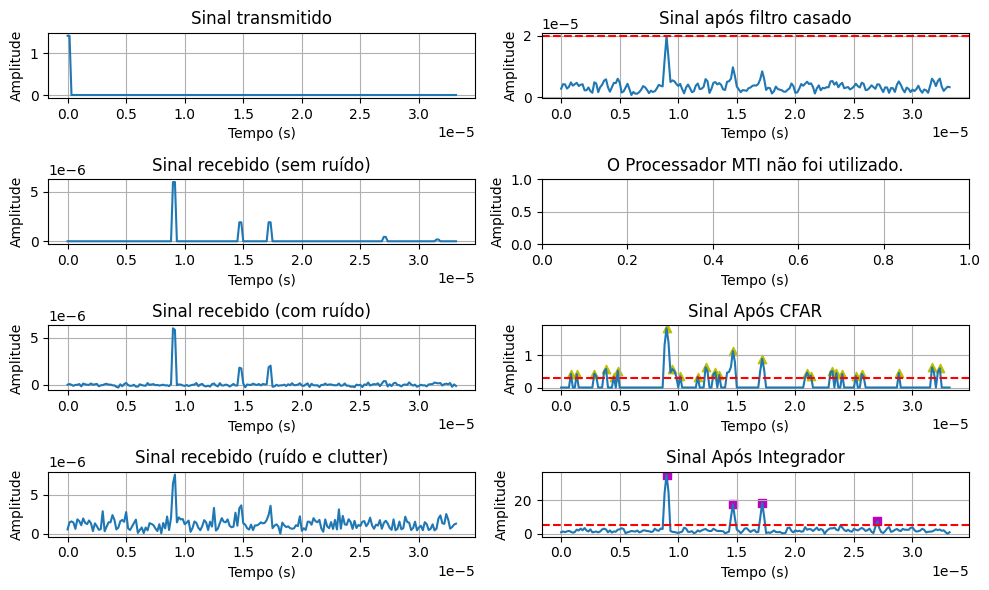

In [20]:
# Criar janela principal
root = tk.Tk()
root.title("Parâmetros do Radar")

tk.Label(root, text="Configurações do Sistema Radar e do Ambiente:", font=("Helvetica", 12, "bold")).grid(row=0, column=0, columnspan=2, sticky="w")
 
# Labels e campos de entrada
tk.Label(root, text="Frequência de Operação (fc) [Hz]:").grid(row=1, column=0, sticky="w")
fc_entry = tk.Entry(root)
fc_entry.insert(0, "1e9")  # Valor padrão
fc_entry.grid(row=1, column=1)

tk.Label(root, text="Potência Transmitida (power_tx) [W]:").grid(row=2, column=0, sticky="w")
power_tx_entry = tk.Entry(root)
power_tx_entry.insert(0, "1e0")  # Valor padrão
power_tx_entry.grid(row=2, column=1)

tk.Label(root, text="Ganho da Antena (G_ant) [dB]:").grid(row=3, column=0, sticky="w")
G_ant_entry = tk.Entry(root)
G_ant_entry.insert(0, "30")  # Valor padrão
G_ant_entry.grid(row=3, column=1)

tk.Label(root, text="Alcance Máximo (R_max) [m]:").grid(row=4, column=0, sticky="w")
R_max_entry = tk.Entry(root)
R_max_entry.insert(0, "5000")  # Valor padrão
R_max_entry.grid(row=4, column=1)

tk.Label(root, text="Alcance Mínimo (R_min) [m]:").grid(row=5, column=0, sticky="w")
R_min_entry = tk.Entry(root)
R_min_entry.insert(0, "50")  # Valor padrão
R_min_entry.grid(row=5, column=1)

tk.Label(root, text="Temperatura Efetiva [K]:").grid(row=6, column=0, sticky="w")
Tea_entry = tk.Entry(root)
Tea_entry.insert(0, "290")  # Valor padrão
Tea_entry.grid(row=6, column=1)

# Campo de entrada para intensidade do clutter
tk.Label(root, text="Intensidade do Clutter:").grid(row=7, column=0, sticky="w")
clutter_intensity_entry = tk.Entry(root)
clutter_intensity_entry.insert(0, "1e-6")  # Valor padrão
clutter_intensity_entry.grid(row=7, column=1)
clutter_intensity_entry.config(state='normal')  # Inicialmente habilitado

tk.Label(root, text="Número de Alvos:").grid(row=8, column=0, sticky="w")
num_targets_slider = tk.Scale(root, from_=1, to=10, orient="horizontal", length=200)
num_targets_slider.set(5)  # Valor padrão
num_targets_slider.grid(row=8, column=1)

# Botão para submeter parâmetros
submit_button = tk.Button(root, text="Submeter Parâmetros do sistema radar e do ambiente", command=submit_params)
submit_button.grid(row=9, column=0, columnspan=2)

tk.Label(root, text="Configurações de Processamento de Sinal:", font=("Helvetica", 12, "bold")).grid(row=11, column=0, columnspan=2, sticky="w")

# Checkbox para clutter
# clutter_var = tk.BooleanVar()
# clutter_checkbox = tk.Checkbutton(root, text="Inserir Clutter", variable=clutter_var)
# clutter_checkbox.grid(row=13, column=0, columnspan=2)

# Habilitar/desabilitar campo de entrada intensidade do clutter
# def toggle_clutter_intensity_entry():
#     if clutter_var.get():
#         clutter_intensity_entry.config(state='normal')  # Habilita a entrada
#     else:
#         clutter_intensity_entry.config(state='disabled')  # Desabilita a entrada
      
# clutter_checkbox.config(command=toggle_clutter_intensity_entry)

# Checkbox para filtro casado
# matched_filter_var = tk.BooleanVar()
# matched_filter_checkbox = tk.Checkbutton(root, text="Ativar Filtro Casado", variable=matched_filter_var)
# matched_filter_checkbox.grid(row=15, column=0, columnspan=2)

# Campo de entrada para do threshold do filtro casado
tk.Label(root, text="Threshold Filtro Casado:").grid(row=16, column=0, sticky="w")
threshold_mf_entry = tk.Entry(root)
threshold_mf_entry.insert(0, "2e-5")  # Valor padrão
threshold_mf_entry.grid(row=16, column=1)
threshold_mf_entry.config(state='normal')  # Inicialmente habilitado

# # Habilitar/desabilitar campo de entrada do threshold do filtro casado com base no checkbox
# def toggle_threshold_mf_entry():
#     if matched_filter_var.get():
#         threshold_mf_entry.config(state='normal')  # Habilita a entrada
#     else:
#         threshold_mf_entry.config(state='disabled')  # Desabilita a entrada
      
# matched_filter_checkbox.config(command=toggle_threshold_mf_entry)

# Checkbox para integrador de pulsos
# int_var = tk.BooleanVar()
# int_checkbox = tk.Checkbutton(root, text="Ativar Integrador de Pulsos", variable=int_var)
# int_checkbox.grid(row=17, column=0, columnspan=2)

# # Habilitar/desabilitar campo de entrada do threshold do integrador com base no checkbox
# def toggle_threshold_int_entry():
#     if int_var.get():
#         threshold_int_entry.config(state='normal')  # Habilita a entrada
#         qnt_int_entry.config(state='normal')  # Habilita a entrada
#     else:
#         threshold_int_entry.config(state='disabled')  # Desabilita a entrada
#         qnt_int_entry.config(state='disabled')  # Habilita a entrada
      
# int_checkbox.config(command=toggle_threshold_int_entry)

#Checkbox para filtro MTI
mti_var = tk.BooleanVar()
mti_checkbox = tk.Checkbutton(root, text="Ativar Filtro MTI", variable=mti_var)
mti_checkbox.grid(row=20, column=0, columnspan=2)

# Campo de entrada para o threshold do MTI
tk.Label(root, text="Threshold do MTI:").grid(row=21, column=0, sticky="w")
mti_threshold_entry = tk.Entry(root)
mti_threshold_entry.insert(0, "1e-25")  # Valor padrão
mti_threshold_entry.grid(row=21, column=1)
mti_threshold_entry.config(state='disabled')  # Inicialmente habilitado

# Campo de entrada para o threshold do MTI
tk.Label(root, text="Máximo desvio Doppler a ser removido pelo MTI:").grid(row=22, column=0, sticky="w")
mti_max_Doppler_entry = tk.Entry(root)
mti_max_Doppler_entry.insert(0, "500")  # Valor padrão
mti_max_Doppler_entry.grid(row=22, column=1)
mti_max_Doppler_entry.config(state='disabled')  # Inicialmente habilitado

# Campo de entrada para o threshold do MTI
tk.Label(root, text="Quantidade de echos considerados pelo MTI:").grid(row=23, column=0, sticky="w")
mti_echoes_entry = tk.Entry(root)
mti_echoes_entry.insert(0, "5")  # Valor padrão
mti_echoes_entry.grid(row=23, column=1)
mti_echoes_entry.config(state='disabled')  # Inicialmente habilitado

# Campo de entrada para o threshold do MTI
tk.Label(root, text="Ganho do processador MTI:").grid(row=24, column=0, sticky="w")
mti_gain_entry = tk.Entry(root)
mti_gain_entry.insert(0, "5")  # Valor padrão
mti_gain_entry.grid(row=24, column=1)
mti_gain_entry.config(state='disabled')  # Inicialmente habilitado

# Habilitar/desabilitar campo de entrada do threshold do MTI com base no checkbox
def toggle_mti_threshold_entry():
    if mti_var.get():
        mti_threshold_entry.config(state='normal')  # Habilita a entrada
        mti_max_Doppler_entry.config(state='normal')  # Inicialmente habilitado
        mti_echoes_entry.config(state='normal')  # Inicialmente habilitado
        mti_gain_entry.config(state='normal')  # Inicialmente habilitado
    else:
        mti_threshold_entry.config(state='disabled')  # Desabilita a entrada
        mti_max_Doppler_entry.config(state='disabled')  # Inicialmente habilitado
        mti_echoes_entry.config(state='disabled')  # Inicialmente habilitado
        mti_gain_entry.config(state='disabled')  # Inicialmente habilitado
        

mti_checkbox.config(command=toggle_mti_threshold_entry)

# Checkbox para filtro CFAR
# cfar_var = tk.BooleanVar()
# cfar_checkbox = tk.Checkbutton(root, text="Ativar Filtro CFAR", variable=cfar_var)
# cfar_checkbox.grid(row=22, column=0, columnspan=2)

# Campo de entrada para o janelamento do CFAR
tk.Label(root, text="Amostras de referência do CFAR:").grid(row=25, column=0, sticky="w")
cfar_reference_window_entry = tk.Entry(root)
cfar_reference_window_entry.insert(0, "50")  # Valor padrão
cfar_reference_window_entry.grid(row=25, column=1)
cfar_reference_window_entry.config(state='normal')  # Inicialmente habilitado

# Campo de entrada para o janelamento do CFAR
tk.Label(root, text="Amostras de guarda do CFAR:").grid(row=26, column=0, sticky="w")
cfar_guard_window_entry = tk.Entry(root)
cfar_guard_window_entry.insert(0, "10")  # Valor padrão
cfar_guard_window_entry.grid(row=26, column=1)
cfar_guard_window_entry.config(state='normal')  # Inicialmente habilitado

# Campo de entrada para o threshold do CFAR
tk.Label(root, text="Threshold do CFAR:").grid(row=27, column=0, sticky="w")
cfar_threshold_entry = tk.Entry(root)
cfar_threshold_entry.insert(0, "0.3")  # Valor padrão
cfar_threshold_entry.grid(row=27, column=1)
cfar_threshold_entry.config(state='normal')  # Inicialmente habilitado

# Habilitar/desabilitar campo de entrada do threshold e janelamento do CFAR com base no checkbox
# def toggle_cfar_threshold_entry():
#     if cfar_var.get():
#         cfar_threshold_entry.config(state='normal')  # Habilita a entrada
#         cfar_window_entry.config(state='normal')  # Habilita a entrada
#     else:
#         cfar_threshold_entry.config(state='disabled')  # Desabilita a entrada
#         cfar_window_entry.config(state='disabled')  # Desabilita a entrada
      
# cfar_checkbox.config(command=toggle_cfar_threshold_entry)

# Campo de entrada para do threshold do integrador de pulsos
tk.Label(root, text="Threshold Integrador de Pulsos:").grid(row=28, column=0, sticky="w")
threshold_int_entry = tk.Entry(root)
threshold_int_entry.insert(0, "5")  # Valor padrão
threshold_int_entry.grid(row=28, column=1)
threshold_int_entry.config(state='normal')  # Inicialmente habilitado

# Campo de entrada para do threshold do integrador de pulsos
tk.Label(root, text="Quantidade de Integrações:").grid(row=29, column=0, sticky="w")
qnt_int_entry = tk.Entry(root)
qnt_int_entry.insert(0, "20")  # Valor padrão
qnt_int_entry.grid(row=29, column=1)
qnt_int_entry.config(state='normal')  # Inicialmente habilitado

# Botão para gerar gráficos dos sinais
apply_button = tk.Button(root, text="Aplicar Configurações de deteção", command=apply)
apply_button.grid(row=31, column=0, columnspan=2)

# Botão para gerar gráficos de detecções
generate_detec_button = tk.Button(root, text="Simular", command=detect_display)
generate_detec_button.grid(row=33, column=0, columnspan=2)

# Iniciar o loop principal da interface
root.mainloop()
plt.close()